<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [98]:
import torch.nn.functional as F
import util
import layers
import os
import logging
import numpy as np
import pandas as pd
import pickle
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm as tqdm

import torchaudio

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [75]:
import IPython.display as ipd
# display(ipd.Audio(xnoise, rate=samplerate));

In [4]:
from torchvision import models
from torchsummary import summary

vgg = models.vgg16()
summary(vgg, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [8]:
config = {
    "dataset": {
        "extract_voice": True,
        "in_memory_percentage": 1,
        "noise_only_percent": 0.1,
        "num_condition_classes": 29,
        "path": "data/NSDTSEA/",
        "regain": 0.06,
        "sample_rate": 16000,
        "type": "nsdtsea"
    },
    "model": {
        "condition_encoding": "binary",
        "dilations": 9,
        "filters": {
            "lengths": {
                "res": 3,
                "final": [3, 3],
                "skip": 1
            },
            "depths": {
                "res": 128,
                "skip": 128,
                "final": [2048, 256]
            }
        },
        "num_stacks": 3,
        "target_field_length": 1601,
        "target_padding": 1
    },
    "optimizer": {
        "decay": 0.0,
        "epsilon": 1e-08,
        "lr": 0.001,
        "momentum": 0.9,
        "type": "adam"
    },
    "training": {
        "batch_size": 10,
        "early_stopping_patience": 16,
        "loss": {
            "out_1": {
                "l1": 1,
                "l2": 0,
                "weight": 1
            },
            "out_2": {
                "l1": 1,
                "l2": 0,
                "weight": 1
            }
        },
        "num_epochs": 250,
        "num_test_samples": 100,
        "num_train_samples": 1000,
        "path": "data/NSDTSEA/"
    }
}

In [61]:
class dilated_residual_block(nn.Module):
    
    def __init__(self, dilation, input_length, padded_target_field_length, config):
        super().__init__()
        self.dilation =  dilation
        self.input_length = input_length
#         self.condition_input_length = condition_input_length
#         self.samples_of_interest_indices = samples_of_interest_indices
        self.padded_target_field_length = padded_target_field_length
        self.config = config
        self.conv1 = nn.Conv1d(self.config['model']['filters']['depths']['res'], 2*self.config['model']['filters']['depths']['res'],
                               kernel_size = self.config['model']['filters']['lengths']['res'], stride=1, bias = False, dilation = self.dilation,
                               padding=int(self.dilation))
        self.conv2 = nn.Conv1d(self.config['model']['filters']['depths']['res'], 
                               self.config['model']['filters']['depths']['res'] + self.config['model']['filters']['depths']['skip'],
                               1, stride=1, bias = False, padding=0)
        
    
    def forward(self, data_x):

        original_x = data_x

        # Data sub-block
        data_out = self.conv1(data_x)

        data_out_1 = layers.slicing(data_out, slice(0, self.config['model']['filters']['depths']['res'],1), 1) 

        data_out_2 = layers.slicing(data_out, slice(self.config['model']['filters']['depths']['res'], 
                                                    2*self.config['model']['filters']['depths']['res'],1), 1)

        data_out_1 = data_out_1
        
        data_out_2 = data_out_2

        tanh_out = torch.tanh(data_out_1)
        sigm_out = torch.sigmoid(data_out_2)

        data_x = tanh_out*sigm_out

        data_x = self.conv2(data_x)

        res_x = layers.slicing(data_x, slice(0, self.config['model']['filters']['depths']['res'],1), 1)
        
        skip_x = layers.slicing(data_x, slice(self.config['model']['filters']['depths']['res'], 
                                self.config['model']['filters']['depths']['res']+self.config['model']['filters']['depths']['skip'],1), 1)

        res_x = res_x + original_x

        return res_x, skip_x

In [27]:
drb = dilated_residual_block(9, 100, 100, config)

In [31]:
summary(drb, (128, 3))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1               [-1, 256, 3]          98,304
            Conv1d-2               [-1, 256, 3]          32,768
Total params: 131,072
Trainable params: 131,072
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.50
Estimated Total Size (MB): 0.51
----------------------------------------------------------------


In [32]:
drb

dilated_residual_block(
  (conv1): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=(9,), dilation=(9,), bias=False)
  (conv2): Conv1d(128, 256, kernel_size=(1,), stride=(1,), bias=False)
)

In [119]:
class DenoisingWavenet(nn.Module):

    def __init__(self, config, input_length=None, target_field_length=None):
        super().__init__()

        self.config = config
        self.num_stacks = self.config['model']['num_stacks']
        if type(self.config['model']['dilations']) is int:
            self.dilations = [2 ** i for i in range(0, self.config['model']['dilations'] + 1)]
        elif type(self.config['model']['dilations']) is list:
            self.dilations = self.config['model']['dilations']

        self.receptive_field_length = util.compute_receptive_field_length(config['model']['num_stacks'], self.dilations, config['model']['filters']['lengths']['res'], 1)

        if input_length is not None:
            self.input_length = int(input_length)
            self.target_field_length = int(self.input_length - (self.receptive_field_length - 1))
        if target_field_length is not None:
            self.target_field_length = int(target_field_length)
            self.input_length = int(self.receptive_field_length + (self.target_field_length - 1))
        else:
            self.target_field_length = int(config['model']['target_field_length'])
            self.input_length = int(self.receptive_field_length + (self.target_field_length - 1))

        self.target_padding = config['model']['target_padding']
        self.padded_target_field_length = self.target_field_length + 2 * self.target_padding
        self.half_target_field_length = int(self.target_field_length / 2)
        self.half_receptive_field_length = int(self.receptive_field_length / 2)
        self.num_residual_blocks = len(self.dilations) * self.num_stacks

        self.config['model']['num_residual_blocks'] = self.num_residual_blocks
        self.config['model']['receptive_field_length'] = self.receptive_field_length
        self.config['model']['input_length'] = self.input_length
        self.config['model']['target_field_length'] = self.target_field_length
        
        # Layers in the model
        self.conv1 = nn.Conv1d(1, self.config['model']['filters']['depths']['res'], self.config['model']['filters']['lengths']['res'], stride=1, bias = False, padding=1)
        
        self.conv2 = nn.Conv1d(self.config['model']['filters']['depths']['res'], self.config['model']['filters']['depths']['final'][0], self.config['model']['filters']['lengths']['final'][0], stride=1, bias = False, padding=1)
        
        self.conv3 = nn.Conv1d(self.config['model']['filters']['depths']['final'][0], self.config['model']['filters']['depths']['final'][1], self.config['model']['filters']['lengths']['final'][1], stride=1, bias = False, padding=1)
        
        self.conv4 = nn.Conv1d(self.config['model']['filters']['depths']['final'][1], 1, 1, stride=1, bias = False, padding=0)
        
        self.dilated_layers = nn.ModuleList([dilated_residual_block(dilation, self.input_length, self.padded_target_field_length, self.config) for dilation in self.dilations])


    def get_target_field_indices(self):

        target_sample_index = self.get_target_sample_index()

        return range(target_sample_index - self.half_target_field_length,
                     target_sample_index + self.half_target_field_length + 1)

    def get_padded_target_field_indices(self):

        target_sample_index = self.get_target_sample_index()

        return range(target_sample_index - self.half_target_field_length - self.target_padding,
                     target_sample_index + self.half_target_field_length + self.target_padding + 1)

    def get_target_sample_index(self):
        return int(np.floor(self.input_length / 2.0))

    def get_condition_input_length(self, representation):

        if representation == 'binary':
            return int(np.ceil(np.log2(self.num_condition_classes)))
        else:
            return self.num_condition_classes

    def forward(self, x):

        data_input = x#['data_input']

        data_expanded = layers.expand_dims(data_input, 1)
        
        data_out = self.conv1(data_expanded)

        skip_connections = []
        for _ in range(self.num_stacks):
            for layer in self.dilated_layers:
                data_out, skip_out = layer(data_out)
                if skip_out is not None:
                    skip_connections.append(skip_out)

        data_out = torch.stack( skip_connections, dim = 0).sum(dim = 0)
        data_out = F.relu(data_out)

        data_out = self.conv2(data_out)

        data_out = F.relu(data_out)
        
        data_out = self.conv3(data_out)

        data_out = self.conv4(data_out)

        data_out_speech = data_out
        data_out_noise = data_input - data_out_speech

        data_out_speech = data_out_speech.squeeze_(1)

        data_out_noise = data_out_noise.squeeze_(1)

        return data_out_speech#, data_out_noise

In [63]:
dw = DenoisingWavenet(config)

In [64]:
dw

DenoisingWavenet(
  (conv1): Conv1d(1, 128, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
  (conv2): Conv1d(128, 2048, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
  (conv3): Conv1d(2048, 256, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
  (conv4): Conv1d(256, 1, kernel_size=(1,), stride=(1,), bias=False)
  (dilated_layers): ModuleList(
    (0): dilated_residual_block(
      (conv1): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (conv2): Conv1d(128, 256, kernel_size=(1,), stride=(1,), bias=False)
    )
    (1): dilated_residual_block(
      (conv1): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,), bias=False)
      (conv2): Conv1d(128, 256, kernel_size=(1,), stride=(1,), bias=False)
    )
    (2): dilated_residual_block(
      (conv1): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=(4,), dilation=(4,), bias=False)
      (conv2): Conv1d(128, 256, kernel_size=(1,), stride=(1,), bias=

In [70]:
summary(dw, (10,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 128, 10]             384
            Conv1d-2              [-1, 256, 10]          98,304
            Conv1d-3              [-1, 256, 10]          32,768
dilated_residual_block-4  [[-1, 128, 10], [-1, 128, 10]]               0
            Conv1d-5              [-1, 256, 10]          98,304
            Conv1d-6              [-1, 256, 10]          32,768
dilated_residual_block-7  [[-1, 128, 10], [-1, 128, 10]]               0
            Conv1d-8              [-1, 256, 10]          98,304
            Conv1d-9              [-1, 256, 10]          32,768
dilated_residual_block-10  [[-1, 128, 10], [-1, 128, 10]]               0
           Conv1d-11              [-1, 256, 10]          98,304
           Conv1d-12              [-1, 256, 10]          32,768
dilated_residual_block-13  [[-1, 128, 10], [-1, 128, 10]]               0
 

In [162]:
waveform, sample_rate = torchaudio.load("wav.wav")
waveform = waveform[:1, :]
waveform = waveform.narrow(1, 0, 10000).T#.squeeze()
waveform.shape

torch.Size([10000, 1])

In [163]:
display(ipd.Audio(waveform.T, rate=sample_rate));

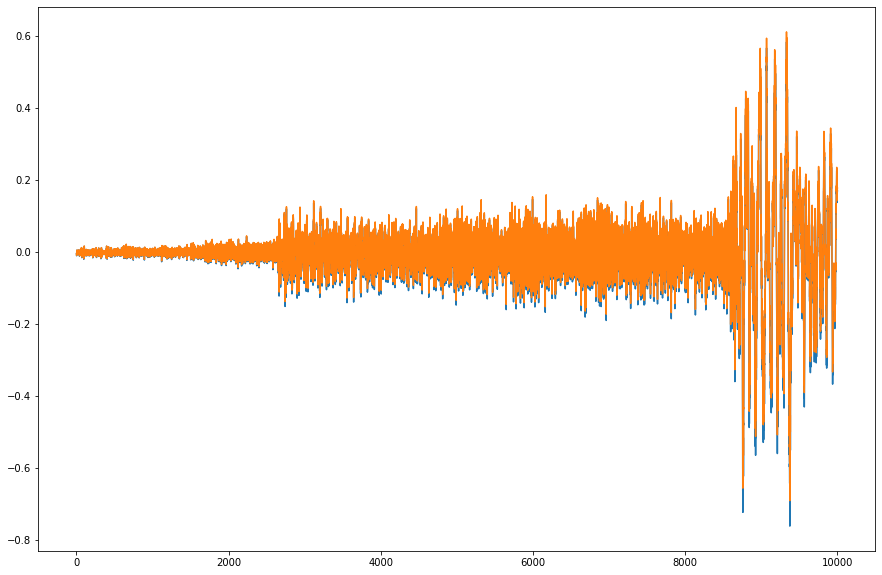

In [172]:
pylab.figure(figsize=(15, 10))
# pylab.plot(waveform.squeeze())
pylab.plot(y.detach().numpy().squeeze())
pylab.plot(waveform.squeeze())

In [133]:
model = DenoisingWavenet(config)
optimizer = optim.Adam(model.parameters())
loss_fn = nn.L1Loss()

In [141]:
waveform, sample_rate = torchaudio.load("wav.wav")
waveform = waveform[:1, :]
waveform = waveform.narrow(1, 0, 1000).T

train_losses = []

for epoch in tqdm(range(1, 5)):
    counter = 0
    model.train()
    batch_losses=[]
    batch_metric=[]
    data = waveform
    while True:
        print(counter, end='\r')
        x, y = torch.clone(data), torch.clone(data)
        optimizer.zero_grad()
#         x = dict(map(lambda i: (i[0], i[1].to(self.device, dtype=torch.float32)), x.items()))
#         y = dict(map(lambda i: (i[0], i[1].to(self.device, dtype=torch.float32)), y.items()))
        y_hat = model(x)
        loss = loss_fn(y_hat, y)
        loss.backward()
        batch_losses.append(loss)
        optimizer.step()
        if counter >= 1:
            break
        counter += 1
    train_losses.append(torch.stack(batch_losses, dim = 0).mean(dim = 0).detach().cpu().numpy())
    print(f'Epoch - {epoch} Train-Loss : {train_losses[-1]}')
    counter = 0





  0%|          | 0/4 [00:00<?, ?it/s]





 25%|██▌       | 1/4 [00:06<00:19,  6.50s/it]

Epoch - 1 Train-Loss : 0.001806743210181594






 50%|█████     | 2/4 [00:12<00:12,  6.41s/it]

Epoch - 2 Train-Loss : 0.0007771392120048404






 75%|███████▌  | 3/4 [00:19<00:06,  6.46s/it]

Epoch - 3 Train-Loss : 0.0010177268413826823






100%|██████████| 4/4 [00:25<00:00,  6.48s/it]

Epoch - 4 Train-Loss : 0.0008266077493317425


In [164]:
y = model(waveform).squeeze()

In [165]:
display(ipd.Audio(y.detach().numpy(), rate=sample_rate));

In [130]:
x.shape

torch.Size([1000, 1, 1, 1])

In [131]:
data.shape

torch.Size([1000, 1, 1, 1])